In [1]:
import numpy as np
import pandas as pd
import scipy 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Grab and process the raw data.
amazon = open('amazon_cells_labelled.txt', mode = 'r+')
text = amazon.readlines()
print ('This file is {} lines long.'.format(len(text)))


This file is 1000 lines long.


In [19]:
# Import nltk
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()

df = pd.read_table('amazon_cells_labelled.txt', names=('Message', 'Sentiment'))

# Lower capital letters
df['Message'] = df.Message.map(lambda x: x.lower())

# Create word vector of keyword features
keywords = ['good', 'excellent', 'great', 'impressed', 'quality', 'recommend', 'loved', 'best', 'ideal', 'well', 'nice', 'right', 'has', 'neat', 'love', 'reasonable', 'works', 'happy', 'cool', 'comfortable', 'beautiful', 'seamlessly', 'fast', 'simple', 'comfortably', 'pleased', 'brilliant', 'nicely']

df['message_tokens'] = df['Message'].apply(lambda row: [ps.stem(w) for w in word_tokenize(row)])

# Stem keywords
stem_keywords = [ps.stem(key) for key in keywords]

# Note that we add spaces around the key so that we're getting the word,
# not just pattern matching.
for key in stem_keywords:
    df[str(key)] = df.Message.str.contains(' ' + str(key) + ' ', case=False)

df

,Message,Sentiment,message_tokens,good,excel,great,impress,qualiti,recommend,love,...,work,happi,cool,comfort,beauti,seamlessli,fast,simpl,pleas,brilliant
0,so there is no way for me to plug it in here i...,0,"[so, there, is, no, way, for, me, to, plug, it...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"good case, excellent value.",1,"[good, case, ,, excel, valu, .]",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,great for the jawbone.,1,"[great, for, the, jawbon, .]",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,tied to charger for conversations lasting more...,0,"[tie, to, charger, for, convers, last, more, t...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,the mic is great.,1,"[the, mic, is, great, .]",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,i have to jiggle the plug to get it to line up...,0,"[i, have, to, jiggl, the, plug, to, get, it, t...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,if you have several dozen or several hundred c...,0,"[if, you, have, sever, dozen, or, sever, hundr...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,if you are razr owner...you must have this!,1,"[if, you, are, razr, owner, ..., you, must, ha...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,"needless to say, i wasted my money.",0,"[needless, to, say, ,, i, wast, my, money, .]",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,what a waste of money and time!.,0,"[what, a, wast, of, money, and, time, !, .]",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
#  Turn the spam column into a boolean so we can easily do some statistics to prepare for modeling
df['Sentiment'] = (df['Sentiment'] == 1)

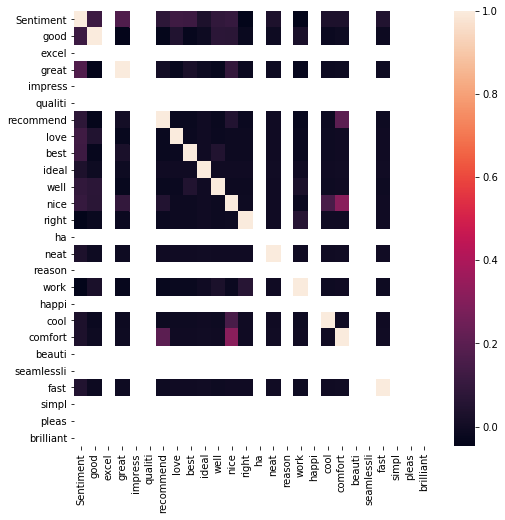

In [5]:
# Create a heatmap to check for independence between variables
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df.corr())

In [6]:
# Define target and training variables
data = df[stem_keywords]
target = df['Sentiment']

In [7]:
# Apply Naive Bayes model to training set and print accuracy
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

bnb.fit(data, target)

y_pred = bnb.predict(data)

print('Number of mislabeled points out of a total {} points : {}'.format(data.shape[0], (target != y_pred).sum()))

Number of mislabeled points out of a total 1000 points : 386


My features are a compilation of kewyords that are explicitely identifiable with positive sentiments. The more keywords that are inlcuded, the more accurate the model predicts the data, but at a decreasing rate (like a square-root function).

In [8]:
# create confusion matrix to visualize errors
# negatives, positives

from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[477,  23],
       [363, 137]])

In [9]:
# Create hold out groups for crosstabing to check for over-fitting

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=30)
print('With 30% holdout: ' + str(bnb.fit(x_train, y_train).score(x_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 30% holdout: 0.61
Testing on Sample: 0.614


In [10]:
# Cross Validation just to make sure theres no overfitting

from sklearn.model_selection import cross_val_score

cross_val_score(bnb, data, target, cv=5)

array([0.62 , 0.615, 0.6  , 0.61 , 0.6  ])